In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

### 1. 文件读入：

In [2]:
# 所有文件的地址：
train_image_path = glob.glob('E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/dc_2000/train/*/*.jpg')
test_image_path = glob.glob('E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/dc_2000/test/*/*.jpg')

In [3]:
len(train_image_path), len(test_image_path)

(2000, 1000)

In [4]:
type( train_image_path[0] ), train_image_path[0]  # 都是字符串形式的图片地址

(str,
 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/dc_2000/train\\cat\\cat.0.jpg')

In [5]:
type( test_image_path[0] ), test_image_path[0]  # 都是字符串形式的图片地址

(str,
 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/dc_2000/test\\cat\\cat.1000.jpg')

### 2. 标签提取：

规律：以\\\作为分隔符，这个地址字符串可以分为3个部分！中间那个cat正好是需要的标签。—— 再顺便把cat转为1，dog转为0。

In [6]:
train_image_label = [ int(p.split('\\')[1] == 'cat') for p in train_image_path]
train_image_label[0]  # 按实际进行了

1

In [7]:
len(train_image_label), train_image_label[:5]

(2000, [1, 1, 1, 1, 1])

In [8]:
test_image_label = [ int(p.split('\\')[1] == 'cat') for p in test_image_path]
test_image_label[0]  # 按实际进行了

1

In [9]:
len(test_image_label), test_image_label[:5]

(1000, [1, 1, 1, 1, 1])

### 3. 加载、预处理、创建数据集：

补充几个函数的使用 + 新操作：
- tf.image.convert_image_dtype(image, tf.float32)：如果image是非float类型，这个函数对其进行数据转换的同时，会自动做归一化！但如果输入的就是float数据类型，那么不会自动做归一化！—— **新操作**
- tf.image.resize：所有图像尺寸统一，可以增减数据量的（有些图删些，有些图增些）！—— **新操作**
- xxx.map( function )：这里xxx是个张量，这里的map函数不是python内置的那个map函数！！这里就是把张量xxx传入function中，并获得返回值！
- AUTOTUNE = tf.data.experimental.AUTOTUNE：自动根据后台cpu情况，帮助进行并行处理！—— **新操作**
- train_dataset.prefetch(AUTOTUNE)：预取到缓存，加速处理！—— **新操作**

In [10]:
# 实际是一个批次的处理：训练数据 + 图像增强！
def pre_processing_train_image(path, label):
    
    # 对训练图像的预处理：
    image = tf.io.read_file( path )                       # 文件读取
    image = tf.image.decode_jpeg( image, channels = 3 )   # 文件解码成jpg图片，并给定图片的通道数（默认为0！）
    image = tf.image.resize( image, [300,300] )           # 等比缩放，不要选裁剪！
    image = tf.cast( image, tf.float32 )                  # 转换数据类型：读入默认是int8
    image = image / 255                                   # 归一化
    
    # 图像增强：前3个最常用！
    image = tf.image.random_crop(image, [256,256,3])  # 随机裁剪：必须是3通道
    image = tf.image.random_flip_left_right(image)    # 随机左右翻转
    image = tf.image.random_flip_up_down(image)       # 随机上下翻转
    # image = tf.image.random_brightness(image, 0.5)    # 随机亮度
    # image = tf.image.random_contrast(image, 0, 1)     # 随机对比度
    
    # 对标签的预处理：每张图作为一个独立的数据，其标签已经在一个列表中，总体形成嵌套列表：[1,1,0] -- [ [1], [1], [0] ]
    label = tf.reshape(label, [1])
        
    return image, label

In [11]:
# 实际是一个批次的处理：测试数据 + 无需图像增强！
def pre_processing_test_image(path, label):
    
    # 对训练图像的预处理：
    image = tf.io.read_file( path )                       # 文件读取
    image = tf.image.decode_jpeg( image, channels = 3 )   # 文件解码成jpg图片，并给定图片的通道数（默认为0！）
    image = tf.image.resize( image, [256,256] )           # 等比缩放，不要选裁剪！
    image = tf.cast( image, tf.float32 )                  # 转换数据类型：读入默认是int8
    image = image / 255                                   # 归一化
    
    # 对标签的预处理：每张图作为一个独立的数据，其标签已经在一个列表中，总体形成嵌套列表：[1,1,0] -- [ [1], [1], [0] ]
    label = tf.reshape(label, [1])
        
    return image, label

In [12]:
# 用tf.data创建输入数据集：
AUTOTUNE = tf.data.experimental.AUTOTUNE   # 新操作：在tf.data模块使用时，会自动根据cpu来情况进行并行计算处理！

# 训练数据：
train_dataset = tf.data.Dataset.from_tensor_slices( (train_image_path, train_image_label) )
train_dataset = train_dataset.map( pre_processing_train_image, num_parallel_calls = AUTOTUNE )  # 这里用到上面预处理的函数
# 测试数据：
test_dataset = tf.data.Dataset.from_tensor_slices( (test_image_path, test_image_label) )
test_dataset = test_dataset.map( pre_processing_test_image, num_parallel_calls = AUTOTUNE )  # 这里用到上面预处理的函数

In [13]:
train_dataset

<ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>

In [14]:
test_dataset

<ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>

In [15]:
# 乱序、批划分：
BATCH_SIZE = 16
# 训练数据：
train_count = len( train_image_path )  # 总数据个数
train_dataset = train_dataset.shuffle(train_count).batch(BATCH_SIZE)  # 乱序 + 划分批次 
train_dataset = train_dataset.prefetch(AUTOTUNE)  # 新操作：预取到缓存：加速处理
# 测试数据：
test_dataset = test_dataset.batch(BATCH_SIZE)  # 乱序 + 划分批次 
test_dataset = test_dataset.prefetch(AUTOTUNE)  # 新操作：预取到缓存：加速处理

In [16]:
# 查看一下：训练数据
train_images, train_labels = next( iter(train_dataset) )
train_images.shape

TensorShape([16, 256, 256, 3])

(<tf.Tensor: id=132, shape=(1,), dtype=int32, numpy=array([0])>,
 <matplotlib.image.AxesImage at 0x214d1420808>)

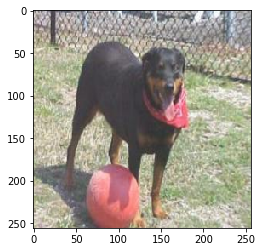

In [17]:
# 验证一下现在是否正确：
train_labels[0], plt.imshow(train_images[0])

In [18]:
# 查看一下：测试数据
test_images, test_labels = next( iter(test_dataset) )
test_images.shape

TensorShape([16, 256, 256, 3])

(<tf.Tensor: id=147, shape=(1,), dtype=int32, numpy=array([1])>,
 <matplotlib.image.AxesImage at 0x214d25c08c8>)

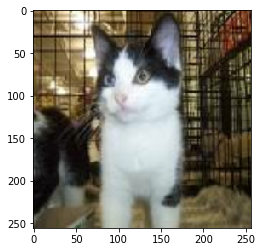

In [19]:
# 验证一下现在是否正确：
test_labels[0], plt.imshow(test_images[0])

### 4. 网络搭建：

说明：**最后Dense输出层**，不管是几分类，**完全可以不激活**！
- 2分类（原sigmoid激活）：不用激活时，输出数值大于0的是一类，小于0的是另一类；
- 多分类（原softmax激活）：不用激活时，选输出数值最大的那个。

In [20]:
# 图像不断缩小，相当于卷积核视野不断变大！
# 1. 加批标准化层：加到每个卷积层、全连接层的后面
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(),
    
#     tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    
#     tf.keras.layers.Dense(256, activation = 'relu'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 252, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 128)     5

In [23]:
# model就是一个可调用对象，现在就可以预测：不准，因为参数都是随机设定的没训练！
# 查看一下：
pred = model(train_images)
pred.shape

TensorShape([16, 1])

In [24]:
# 判断一下结果：因为默认eager模式，可以和python语法自然交互：
pred_labels = np.array( [ p[0].numpy() for p in tf.cast(pred > 0, tf.int32) ] )  # np.array改成横着打印
pred_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [25]:
# 真实标签：
real_labels = np.array( [ p[0].numpy() for p in tf.cast(train_labels > 0, tf.int32) ] )
real_labels

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0])

### 5. 自定义优化器对象、损失函数对象、指标对象：

自定义损失函数时：
- 大写字面：可迭代对象创建器，创建一个可调用对象并用变量绑定，以后调用该对象时再传参数！！
- 小写字母：就是一个**函数**，此时使用就要传入参数，函数返回值传给绑定的变量。

In [26]:
# 自定义损失函数：train、test可以公用的！—— 无需每个epoch重置！
train_loss_func = tf.keras.losses.BinaryCrossentropy( from_logits = True ) # 没激活，得告知
test_loss_func =tf.keras.losses.BinaryCrossentropy( from_logits = True )

In [33]:
# 测试1：可调用对象，使用时再传入参数！
train_loss_func( [1.0,2.1,3.2,4.4], [1.5, 2.2, 1.8, 3.7] ) # 真实序列、预测序列之间的2元交叉熵（里面必须是float！）！

<tf.Tensor: id=1972, shape=(), dtype=float32, numpy=-4.619026>

In [34]:
# 测试2：每个数据都是独立的也可以！
train_loss_func( [[1.0],[2.1],[3.2],[4.4]], [[1.5], [2.2], [1.8], [3.7]] )

<tf.Tensor: id=2004, shape=(), dtype=float32, numpy=-4.619026>

In [32]:
# 测试3：用小写字母函数
train_loss_func_small = tf.keras.losses.binary_crossentropy([1.0,2.1,3.2,4.4], [1.5, 2.2, 1.8, 3.7])
train_loss_func_small

<tf.Tensor: id=1948, shape=(), dtype=float32, numpy=-25.683174>

In [35]:
# 自定义优化器对象：训练数据用
optimizer = tf.keras.optimizers.Adam( learning_rate = 0.001 )

In [36]:
# 自定义指标对象：必须每个epoch后重置！
train_loss = tf.keras.metrics.Mean('train_loss')
train_accuracy = tf.keras.metrics.Accuracy()  # 最简单粗暴的正确率评估

test_loss = tf.keras.metrics.Mean('test_loss')
test_accuracy = tf.keras.metrics.Accuracy()

In [37]:
# 测试一下：
train_accuracy( [1, 0, 1], [1, 1, 1] )

<tf.Tensor: id=2073, shape=(), dtype=float32, numpy=0.6666667>

In [38]:
train_accuracy.reset_states()  # 下面是同名的，这里不重置的话会一直做记录的！

### 6. 自定义每个batch训练的函数：

In [121]:
# 每个batch的训练函数：
def train_epoch( model, images, labels_real ):
    
    with tf.GradientTape() as t:  # 定义t要跟踪哪些函数的梯度变化！
        labels_predict = model(images)                      
        loss_step = train_loss_func(labels_real, labels_predict)  # 损失函数
        
    grads = t.gradient( loss_step, model.trainable_variables )          # 对“总”loss_step做下降！
    optimizer.apply_gradients( zip(grads, model.trainable_variables) )  # 用算好的梯度值优化可训练参数
    
    train_loss( loss_step )  # 每个batch中所有图的误差的均值
    train_accuracy( labels_real, tf.cast( labels_predict > 0, tf.int32) )  # 记得转一下数据类型

In [122]:
def test_epoch( model, images, labels_real ):
    labels_predict = model(images, training = False)  # 非训练模式，也可写成：model.predict(images)！！
    loss_step = test_loss_func(labels_real, labels_predict)
    
    test_loss(loss_step)
    test_accuracy( labels_real, tf.cast( labels_predict > 0, tf.int32 ) )

### 7. 自定义总体训练函数：

In [123]:
# 把每个epoch的loss值和acc值进行记录：
train_loss_results = [] 
train_acc_results = []

test_loss_results = [] 
test_acc_results = []

num_epochs = 30

In [84]:
def train():
    
    for epoch in range(num_epochs):
        
        for (images, labels_real) in train_dataset:
            train_epoch( model, images, labels_real )  # 每个batch的训练
            print('.', end = '')  # 每训练完一个batch，打印一个点；每训练完一个epoch，换一行
        print('')        
        # 每个epoch，记录一下这两个指标（训练集）
        train_loss_results.append( train_loss.result() )
        train_acc_results.append( train_accuracy.result() )
        
        # 每个epoch测试一次：
        for (images, labels_real) in test_dataset:
            test_epoch( model, images, labels_real )  # 每个batch的测试
        # 每个epoch，记录一下这两个指标（测试集）
        test_loss_results.append( test_loss.result() )
        test_acc_results.append( test_accuracy.result() )
        
        
        # 每个epoch结束，打印一次：
        print('Epoch{}：train_loss：{:.3f}，train_accuracy：{:.3f}；test_loss：{:.3f}，test_accuracy：{:.3f}'.format(
            epoch+1, 
            train_loss.result(), 
            train_accuracy.result(),
            test_loss.result(),
            test_accuracy.result()))
        
        # 指标对象每个epoch完后重置：
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states() 

In [ ]:
train()

In [ ]:
# 训练数据绘图：
plt.plot( range(1,num_epochs+1), train_accuracy.result(), label = 'train_accuracy' )
plt.plot( range(1,num_epochs+1), train_loss.result(), label = 'train_loss' )
plt.legend()

In [ ]:
# 测试数据绘图：
plt.plot( range(1,num_epochs+1), test_accuracy.result(), label = 'test_accuracy' )
plt.plot( range(1,num_epochs+1), test_loss.result(), label = 'test_loss' )
plt.legend()

# 总结

解决拟合度不够的方法：train上的准确度就不够高！
- 增大网络容量 + 批标准化层

解决过拟合的方法：
- 增加训练样本（首要）—— 若实在没更多的样本，就**图像增强**：只在train数据上进行，不在test上进行！！
- 加dropout层